In [11]:
import sys

sys.path.append('c:\\Users\\nkwan\\Desktop\\school\\capstone\\code\\legume')

In [12]:
import numpy as np
import legume
import chickpea
from chickpea.cma import CavityModeAnalysis
import matplotlib.pyplot as plt

%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Background

One of the most important parameters in a simulation using Legume is gmax. In a simulation, Legume performs a spatial fourier transform of the crystal. Gmax determines when the resulting fourier series is truncated. This has implications for the accuracy of the resulting simulation, as well as memory usage and runtime.

To illustrate some of the effects of gmax, let's initialize an H2 cavity as we did in the first notebook.

In [13]:
Nx, Ny = 16, 16
supercell = [Nx, Ny]

#we can modify this to suit our needs
thickness = 0.71
eps = 12.0
rad = 0.348
cavType = 'H'
n = 2

crystal = chickpea.PhotonicCrystalCavity(cavType, supercell, thickness, rad, eps, n)
phc = crystal.cavity()
base = crystal.get_base_crystal()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

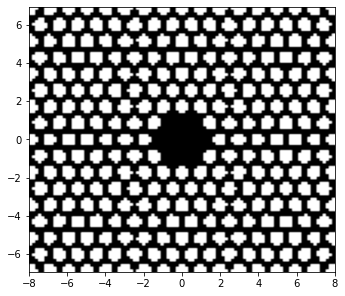

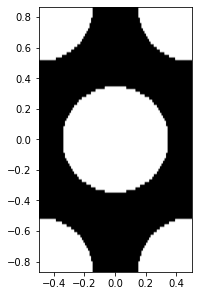

In [5]:
legume.viz.eps_xy(phc, z=thickness/2)
legume.viz.eps_xy(base, z=thickness/2, Nx=100, Ny=100)

Now, we construct the Cavity mode analysis object.

In [14]:
defectMargins = np.array([0.25, 0.25])
cma = CavityModeAnalysis(phc, base, defectMargins, layer=0, gmax=2, base_gmax=3)
#using this method places some constraints on the parameters

[0.37254045]
Band gap lower bound: 0.261561.
Band gap upper bound: 0.381308.
Band gap center: 0.321434.
Gap-midgap ratio: 0.372540.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



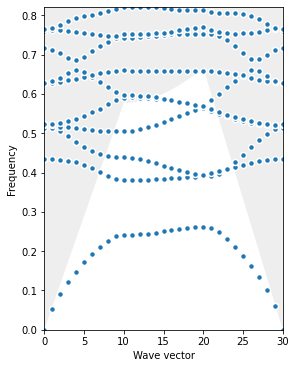

In [15]:
bandgaps, k_air, k_eps = cma.find_band_gaps(band_tol = 0.1, order=np.array([0]), trim_lc = True, lc_trim = 0.04, numeig=10)

gmg_ratio = np.array([(bandgap[1]-bandgap[0]) / bandgap[2] for bandgap in bandgaps])
legume.viz.bands(cma.base_gme, trim_light_cone = False, lc_trim = 0.04)
print(gmg_ratio)

print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (bandgaps[0][0], bandgaps[0][1], bandgaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))


Before we run any simulations, let's use Legume's viz.eps_ft method to look at how Legume "sees" our crystal for integer gmax values from 1 to 6. Notice the increase in fidelity as gmax increases.

In [23]:
viz_gmaxes = range(1, 7)
for gmax in viz_gmaxes:
    gme = legume.GuidedModeExp(phc, gmax)
    legume.viz.eps_ft(gme, figsize=5)

KeyboardInterrupt: 

In [ ]:
options = {'verbose': True,
           'gmode_inds': [0],
           'gradients': 'approx',
           'eig_solver': 'eigsh', #for better memory usage and runtime
           'numeig': 1,
           'eig_sigma': 0.341, #we target this particular mode.
           'compute_im': False
}

To observe convergence with gmax, we require a large enough supercell. Internally in Legume, gmax is scaled by 2\pi and truncated to an integer. So, our input into gmax doesn't need to be an integer.

In [ ]:
gmax_low = 1.
gmax_high = 5.
stepsize = 0.5#1.001/(2*np.pi)
gmax_array = np.arange(gmax_low, gmax_high, stepsize)
kpoints = np.array([[k_air[0][0]], [k_air[1][0]]])

Now, we're ready to simulate over a range of gmax values. Note the runtime and memory usage, as well as the resulting Q-factor value for each gmax.

In [27]:
q_list = []
for gmax in gmax_array:
    gme = legume.GuidedModeExp(phc, gmax)
    %memit gme.run(kpoints=kpoints, **options)
    freq_im, _, _ = gme.compute_rad(0, [0])
    q_list.append(gme.freqs[0, 0]/2/freq_im[0])

plt.plot(gmax_array, q_list)
plt.xlabel("gmax")
plt.ylabel("q-factor")
plt.show()


1.6608s total time for real part of frequencies, of which
  0.2310s for guided modes computation using the gmode_compute='exact' method
  0.1060s for inverse matrix of Fourier-space permittivity
  0.2371s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 663.04 MiB, increment: 139.18 MiB
Running k-point 1 of 1

MemoryError: Unable to allocate 61.6 MiB for an array with shape (2009, 2009) and data type complex128